In [1]:
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd

import blackbody as bb
import detailedbalance as db
import plots as plots
from load import *

#font = {'size' : 14}

matplotlib.rc('font',**{'size' : 16})
%matplotlib inline

In [2]:
# Just some constants for the upcoming math
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant in eV s')
e = constants.value('elementary charge')
k = constants.value('Boltzmann constant in eV/K')

pi = 3.1415

# Globals
Tcell = 300  # Kelvin
# Band Gap
Egap = 1.1  #electron volts
#Solar dimensions, used to calculate solid angle of earth wrt sun, which is used in sq limit, or for sanity checking
r_earth = 6e6
r_sun = 6.95e8
d_sun = 1.50e11

In [3]:
#Settings for calculating the spectral radiance of the blackbody.
settingsdict = {
    "Solar": {
        "Temp": 5750, # deg C
        'solidangle' : bb.solid_angle(r_earth,d_sun),
        'emitterarea' : 4*pi*r_sun**2,
        'absorberarea' : pi*r_earth**2
    },
    "1800_flat": {
        "Temp": 1800,
        'solidangle' : 2*pi,
        'emitterarea' : 1,
        'absorberarea' : 1
    },
    "1800_cam": {
        "Temp": 1800,
        'solidangle' : bb.solid_angle(1e-2,1), # assume 1 cm sensor size 1 meter away
        'emitterarea' :  1e-4,
        'absorberarea' : 1e-4
    }    
    
}
#Pick setting here
constants = settingsdict['1800_cam']

In [4]:
#Calculation of spectral radiance from blackbody source

E_ph = np.arange(0.01, 4,0.001) 
#E_ph = np.flip(E_ph,0)
    
emissivity = bb.stepfn(1,1,1.1,E_ph)
#emissivity = bb.lorentzian(0,1,1.5,0.1,E_ph)

BB = bb.rad_blackbody(E_ph,constants)
BB = BB * emissivity

#check integrated irradiance is ~1kW/m^2 in the case of solar radiation
# integrate = -np.trapz(BB,BB.index )
# print(integrate)

BB_ph = bb.power_to_photons(BB)

#print(bb.stephan(5750)*4*pi*r_sun**2)

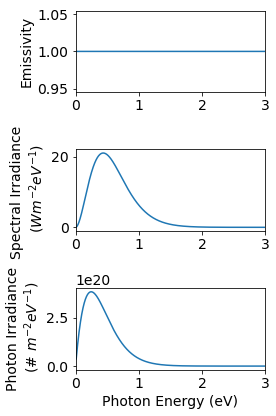

In [5]:
plots.em_ir_ph_plot(BB, BB_ph, emissivity)

In [8]:
QE = read_QE('CamQE\\DCC3240N QE.csv',BB_ph)

shortpass = read_filter('Filters\\FES1000.csv',BB_ph)

filt = read_filter('Filters\\FL05514.csv',BB_ph)
#filt = read_filter('Filters\\FL05850-10.csv',BB_ph)

(0, 3)

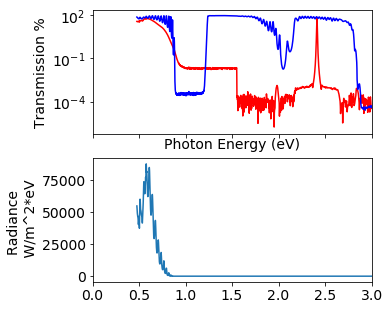

In [9]:
#Radiant flux before camera


BB_filt = BB*filt*shortpass
fig, axes = plt.subplots(2,1 , figsize = (5,5) ,sharex = True)
axes[0].set_ylabel('Transmission %')
axes[0].plot(filt, color = 'red')
axes[0].plot(shortpass, color = 'b')
axes[0].set_yscale('log')
axes[0].set_xlabel('Photon Energy (eV)')

axes[1].plot(BB_filt)
#axes[1].set_yscale('log')
#axes[1].set_ylim(0,100)
axes[1].set_ylabel('Radiance \n W/m^2*eV')

plt.xlim(0,3)

# BB_filt[np.isnan(BB_filt)] = 0
# integral = np.trapz(BB_filt,BB_filt.index)
# integral

(0, 3)

C:\Users\aspit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


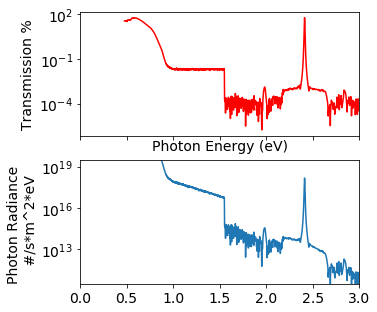

In [10]:
#Photon Flux
BB_ph_filt = BB_ph*filt
fig, axes = plt.subplots(2,1 , figsize = (5,5) ,sharex = True)
axes[0].set_ylabel('Transmission %')
axes[0].plot(filt, color = 'red')
axes[0].set_yscale('log')
axes[0].set_xlabel('Photon Energy (eV)')

axes[1].plot(BB_ph_filt)
axes[1].set_yscale('log')
axes[1].set_ylim(3e10,3e19)
axes[1].set_ylabel('Photon Radiance \n #/s*m^2*eV')


plt.xlim(0,3)

(0, 3)

C:\Users\aspit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


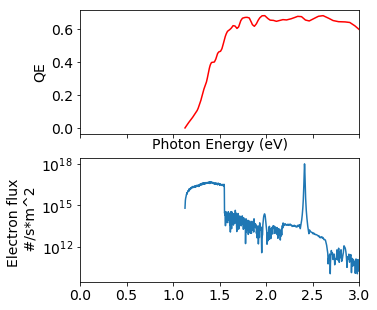

In [11]:

eflux = QE*BB_ph_filt

fig, axes = plt.subplots(2,1 , figsize = (5,5) ,sharex = True)
axes[0].set_ylabel('QE')
axes[0].plot(QE, color = 'red')
#axes[0].set_yscale('log')
axes[0].set_xlabel('Photon Energy (eV)')

axes[1].plot(eflux)
axes[1].set_yscale('log')
axes[1].set_ylabel('Electron flux \n #/s*m^2')


plt.xlim(0,3)

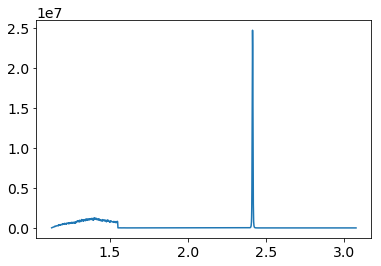

In [12]:
detectorarea = (5e-6)**2
erate = eflux*detectorarea

plt.plot(erate)


In [13]:
erate[np.isnan(erate)] = 0
totalerate = np.trapz(erate[1:3],erate[1:3].index)
totalerate

469275.75596947136

At 1800 C:
FL05514.csv :  0.005 W/m^2
FL05850-10.csv :  0.623 W/m^2


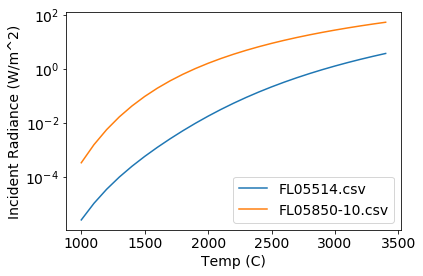

In [14]:
temps = list(range(1000,3500,100))
origtemp = constants['Temp']
filepaths = ['Filters\\FL05514.csv','Filters\\FL05850-10.csv']
columns = [os.path.split(filepath)[1] for filepath in filepaths]
ints = pd.DataFrame(index = temps, columns = columns)

for fname in ints.columns:  
    filepath = os.path.join('Filters', fname)
    filt = read_filter(filepath, BB)
    for temp in temps:
        constants['Temp'] = temp
        BB = bb.rad_blackbody(E_ph,constants)
        BB = BB * emissivity
        #BB_ph = bb.power_to_photons(BB)
        BB_filt = BB*filt
        absorbed = BB_filt*QE
        absorbed[np.isnan(absorbed)] = 0
        absorbed = absorbed[1.1:]
        ints[fname][temp] = np.trapz(absorbed,absorbed.index)
        #plt.plot(BB_filt)
constants['Temp'] = origtemp
        
ax = ints.plot()
ax.set_yscale('log')
ax.set_xlabel('Temp (C)')
ax.set_ylabel('Incident Radiance (W/m^2)')


print('At 1800 C:')
for fname in ints.columns:
    integral = '{0:.3f}'.format(ints[fname][1800])
    print(fname, ': ' , integral, 'W/m^2')
